# Imports 

In [1]:
%%capture
# !pip install xarray
# !pip install wandb
# !pip install netcdf4
# !pip install collections
# !pip install scikit-image
# !pip install pysteps
!pip install xclim
!pip install ibicus

In [2]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [3]:
import numpy as np
from torch.utils import data
from src.utils import *
import xarray as xr
from scipy.ndimage import convolve
from skimage.transform import rescale
import torch

from xclim import sdba
from src.utils_essential import *

from ibicus.debias import QuantileMapping, QuantileDeltaMapping, ISIMIP

from src.dataloader_sr import ERA5_P_0_25_to_1_Dataset, QM_GFDL_LR_Dataset_64, gfdl_eval_ssp585_1d, gfdl_eval

/usr/local/lib/python3.10/dist-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



# Prepare dataloaders (QM of 1d data)

In [4]:
bs_valid = 7300

In [5]:
gfdl_ssp585_ds = gfdl_eval("1995_2014")
gfdl_ssp585_dl = data.DataLoader(gfdl_ssp585_ds, batch_size=bs_valid, shuffle=False,drop_last=True)

gfdl_ssp585 = next(iter(gfdl_ssp585_dl))
print("GFDL SSP585 1d 64 shape:",gfdl_ssp585.shape)

GFDL SSP585 1d 64 shape: torch.Size([7300, 1, 64, 64])


In [6]:
era5_p_0_25_to_1_t = ERA5_P_0_25_to_1_Dataset(stage='all')
dataloader_era5_train_1d_64 = data.DataLoader(era5_p_0_25_to_1_t.data(), batch_size=8371
                                              , shuffle=False, drop_last=True,num_workers=2)
era5_train = next(iter(dataloader_era5_train_1d_64)).unsqueeze(dim=1)
print("ERA5 1d 64 shape:",era5_train.shape)

era5 <class 'xarray.core.dataarray.DataArray'> (8401, 64, 64)
dataset size (8371, 64, 64)
ERA5 1d 64 shape: torch.Size([8371, 1, 64, 64])


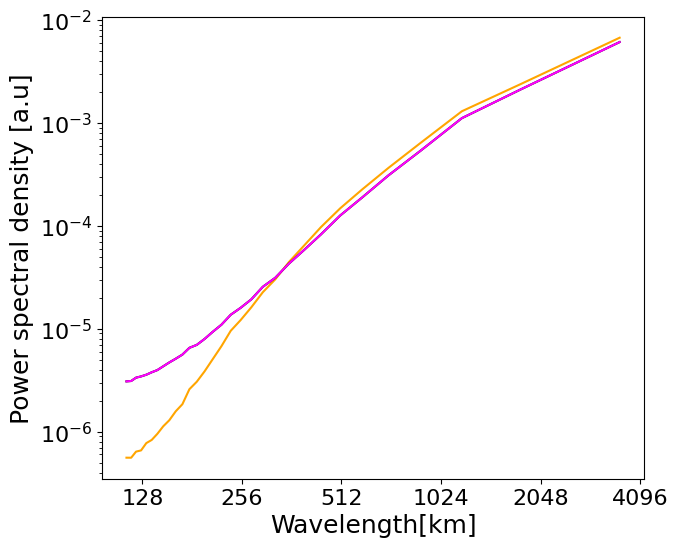

In [8]:
ssd = SpatialSpectralDensity_diff_res( gfdl_ssp585.numpy()
                                     ,era5_train.numpy()
                                     ,era5_train.numpy()
                                     ,new_labels = ["gfdl",None,"era5"])
ssd.run(num_times=None)
ssd.plot_psd(fname="",model_resolution=1, model_resolution_2 = 1)

In [9]:
len(gfdl_ssp585_ds), len(era5_p_0_25_to_1_t), len(gfdl_ssp585_ds)/365

(7300, 8371, 20.0)

In [10]:
era5_p_0_25_to_1_t.get_mean_std()

mean: 0.37070283
std: 0.39181525
min: -0.9461164
max: 5.897021


(0.37070283, 0.39181525, -0.9461164, 5.897021)

# Apply QM debiasing to gfdl ssp585 validation 

In [11]:
train_era5 = era5_p_0_25_to_1_t.inverse_dwd_trafo(era5_train)[-7300:,:,:,:].squeeze(1).numpy()
train_gfdl = gfdl_ssp585[:7300,:,:,:].squeeze(1).numpy()
valid_gfdl = gfdl_ssp585.squeeze(1).numpy()

In [12]:
train_era5.shape, train_gfdl.shape

((7300, 64, 64), (7300, 64, 64))

In [13]:
debiased_valid_gfdl = np.zeros((7300, 64, 64)) 

# Create synthetic time coordinates
time_coords_long = xr.cftime_range("1992-01-01", periods=7300, freq="D", calendar="gregorian")
time_coords_short = xr.cftime_range("2011-01-01", periods=7300, freq="D", calendar="gregorian")


for lat in range(train_era5.shape[1]):
    for lon in range(train_era5.shape[2]):

        qm = sdba.adjustment.QuantileDeltaMapping
        #qm = sdba.adjustment.EmpiricalQuantileMapping
        

        ref_data = train_era5[:, lat, lon]
        hist_data = train_gfdl[:, lat, lon]
        input_data = valid_gfdl[:, lat, lon]

        # Pass DataArray instead of Dataset
        ref_data_array = xr.DataArray(ref_data, dims="time", coords={"time": time_coords_long}, attrs={"units": "dimensionless"})
        hist_data_array = xr.DataArray(hist_data, dims="time", coords={"time": time_coords_long}, attrs={"units": "dimensionless"})
        input_data_array = xr.DataArray(input_data, dims="time", coords={"time": time_coords_short}, attrs={"units": "dimensionless"})

        # Specify the group and other parameters
        group = sdba.adjustment.Grouper("time")

        Adj = qm.train(
            ref_data_array,
            hist=hist_data_array,
            nquantiles=100,      # 100 was good
            group=group,
            skip_input_checks=True
        )


        mapped = Adj.adjust(input_data_array, skip_input_checks=False)
        debiased_valid_gfdl[:, lat, lon] = mapped

print("Processing completed.")

/tmp/ipykernel_1598476/4247543827.py:4: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  time_coords_long = xr.cftime_range("1992-01-01", periods=7300, freq="D", calendar="gregorian")
/tmp/ipykernel_1598476/4247543827.py:5: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  time_coords_short = xr.cftime_range("2011-01-01", periods=7300, freq="D", calendar="gregorian")


Processing completed.


In [14]:
np.min(debiased_valid_gfdl), np.max(debiased_valid_gfdl) 

(-0.05884976218284721, 157.58302190326162)

## save QM results

In [15]:
np.min(debiased_valid_gfdl), np.max(debiased_valid_gfdl), debiased_valid_gfdl.shape

(-0.05884976218284721, 157.58302190326162, (7300, 64, 64))

In [16]:
do_clipping_before_saving = True
if do_clipping_before_saving == True:
    debiased_valid_gfdl = np.clip(debiased_valid_gfdl,0,2000)

In [17]:
np.min(debiased_valid_gfdl), np.max(debiased_valid_gfdl), debiased_valid_gfdl.shape

(0.0, 157.58302190326162, (7300, 64, 64))

In [18]:
do_save_qm_gfdl = False

if do_save_qm_gfdl == True: 
    torch.save(debiased_valid_gfdl, "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/data/pr_QDM_GFDL_1995_2014_r1i1p1f1_original_units.pth")
    print("saving quantile mapped gfdl 1995-2014 dataset")

saving quantile mapped gfdl 1995-2014 dataset
